# Robustness Report: Resnet152
Accuracy on a benchmark dataset is one measure of model performance. A model’s robustness to common data manipulations is a less commonly-used but important evaluation criterion. This notebook evaluates how robust imagenet models are to data augmentations from [AugLy](https://github.com/facebookresearch/AugLy). This notebook is designed to be easily reused to evaluate model robustness. Please refer to the instructions below to modify it as needed for your own model.

## Summary
This notebook evaluates the robustness of the Resnet152 model, trained on ImageNet, to 17 image modifications from the AugLy data augmentation library. These 17 modifications cover a diverse set of image manipulations, from blur and color jitter, to textual overlays. We report change in classification accuracy after applying these modifications, and compare the change in accuracy to 2 baseline models, VGG16 and Efficientnet-L2. Our results show that the Resnet152 is about as vulnerable to image modifications as VGG16 and significantly less robust than Efficientnet-L2.

In [1]:
import json
import math
import os
import random
import tempfile
import timm
import torch
import augly.image as imaugs
import pandas as pd
import plotly.express as px
from IPython.display import display
from PIL import Image
from torchvision import models, transforms
from torchvision.utils import save_image
from typing import Tuple

## Constants & set up
If you want to run this notebook on another model, you may need to change constants in the 2 cells below this. The rest of the cells in this section are reusable code & set up that you should not need to change.

In [2]:
# Replace these constants corresponding to the model you want to evaluate!

# The name of your model (loadable using `timm.create_model()`) or a
# function to load your model (e.g. from `torchvision.models`)
model_name = models.resnet152

# The size your model expects images' width & height to be
model_input_size = 384

# The local dir where you have the imagenet validation dataset
dataset_dir = "/checkpoint/zoep/imagenet_analysis/imagenet_val"

# The local path where you have the imagenet val data table json file
data_table_path = (
    "/checkpoint/zoep/imagenet_analysis/imagenet_val_data_table.json"
)

# The local dir where the imagenet val images will be augmented & stored
aug_dataset_dir = "/checkpoint/zoep/imagenet_analysis/imagenet_val_aug"

# The local dir where the precomputed CSVs of metrics for
# VGG/Resnet/Efficientnet are; if you have changed the seed or num_images
# constants below then set this to None so the metrics are all re-computed;
# otherwise the metrics will be loaded from the CSVs to avoid wasting
# computation
precomputed_model_metrics_dir = "/checkpoint/zoep/imagenet_analysis/"

In [3]:
# Only change these constants if you have a reason to

# Set to True if you want to recompute all the model metrics
# (i.e. if you change the set of images you're evaluating on)
recompute_model_metrics = False

# Keeps the images sampled deterministic
seed = 1245

# The number of images to evaluate on
num_images = 250

# The number of images to run through each model at once; larger batch
# size can cause CUDA to run out of memory depending how much memory
# your GPUs have
batch_size = 20

In [4]:
# Send model + inputs to different devices
devices = [
    torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    torch.device("cuda:1" if torch.cuda.is_available() else "cpu"),
]

In [5]:
# Processing transformations which will be applied to all images
base_transforms = [
    lambda path: Image.open(path),
    lambda image: image.convert(mode="RGB"),
    transforms.Resize(800),
    transforms.CenterCrop(800),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
]

# For the model input above, the image dimensions might be different
custom_model_transforms = [
    lambda path: Image.open(path),
    lambda image: image.convert(mode="RGB"),
    transforms.Resize(model_input_size),
    transforms.CenterCrop(model_input_size),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
]

# The augmentations we want to test robustness to
augmentations = {
    "blur": imaugs.Blur(radius=3),
    "random_noise": imaugs.RandomNoise(mean=0.1, var=0.2),
    "sharpen": imaugs.Sharpen(factor=10),
    "encoding_quality": imaugs.EncodingQuality(quality=15),
    "change_aspect_ratio": imaugs.ChangeAspectRatio(ratio=3.0),
    "opacity": imaugs.Opacity(level=0.5),
    "pixelization": imaugs.Pixelization(ratio=0.3),
    "scale": imaugs.Scale(factor=0.5),
    "color_jitter": imaugs.ColorJitter(
        brightness_factor=1.6,
        contrast_factor=1.6,
        saturation_factor=1.6,
    ),
    "hflip": imaugs.HFlip(),
    "perspective_transform": imaugs.PerspectiveTransform(),
    "rotate": imaugs.Rotate(degrees=50),
    "vflip": imaugs.VFlip(),
    "overlay_emoji": imaugs.OverlayEmoji(y_pos=0.3, emoji_size=0.8),
    "overlay_text": imaugs.OverlayText(font_size=0.5, x_pos=0.2, y_pos=0.1),
    "overlay_stripes": imaugs.OverlayStripes(
        line_angle=-30,
        line_density=0.9,
        line_width=0.4,
        line_type="dashed",
    ),
    "meme_format": imaugs.MemeFormat(),
}

In [6]:
def sample_images():
    with open(data_table_path) as data_table_file:
        data_table = json.load(data_table_file)
            
    df = pd.DataFrame(data_table["data"])
    df.columns = ["filepath", "class", "class_name"]
    df["filepath"] = df["filepath"].apply(
        lambda path: os.path.basename(os.path.dirname(path))
    )
    df = df.drop_duplicates()
    class_dir_to_id = dict(
        zip(df["filepath"], [str(c) for c in df["class"]]),
    )
        
    sampled_test_images = []
    image_path_to_class_id = {}
    class_id_to_image_paths = {}
    for class_id in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_id)
        if data_table_path is not None:
            class_id = class_dir_to_id[class_id]
        image_paths = os.listdir(class_dir)

        sampled_images = random.sample(image_paths, k=2)
        sampled_test_images.extend(
            [os.path.join(class_dir, image) for image in sampled_images]
        )
        image_path_to_class_id.update(
            {path : class_id for path in sampled_test_images[-2:]}
        )
        class_id_to_image_paths[int(class_id)] = sampled_test_images[-2:]
        
    sampled_test_images = random.sample(sampled_test_images, k=num_images)
    print(f"Sampled {num_images} images to evaluate on")
    return (
        sampled_test_images,
        image_path_to_class_id,
        class_id_to_image_paths,
    )


def augment_images(images, dataset, num_images=num_images):
    num_images = num_images or len(images)
    num_augs = len(augmentations.keys())
    print(f"Augmenting {num_images} images using {num_augs} augmentations")
    
    if not os.path.exists(aug_dataset_dir):
        os.mkdir(aug_dataset_dir)

    aug_images = {}
    for i, image in enumerate(images[:num_images]):
        if (i + 1) % 50 == 0:
            print(f"Augmented {i + 1}/{len(images)} images")
            
        aug_images_dict = {}
        for aug_name, aug in augmentations.items():
            aug_fp = os.path.join(
                aug_dataset_dir,
                f"{image.split('/')[-1].split('.')[0]}_{aug_name}.png",
            )
            aug_images_dict[aug_name] = aug_fp
            if os.path.exists(aug_fp):
                continue
                
            eval_transform = transforms.Compose(
                base_transforms[:1] + [aug] + base_transforms[1:]
            )
            save_image(eval_transform(image), aug_fp)
        aug_images[image] = aug_images_dict

    return aug_images


def get_model(name):
    if name == "efficientnet_l2":
        model = timm.create_model("tf_efficientnet_l2_ns", pretrained=False)
        model.load_state_dict(
            torch.load(
                os.path.join(
                    precomputed_model_metrics_dir,
                    "tf_efficientnet_l2_ns-df73bb44.pth",
                )
            )
        )
    else:
        model = (
            timm.create_model(name, pretrained=True)
            if isinstance(name, str)
            else name(pretrained=True)
        )

    model.eval()
    model = model.half()
    model.to(devices[1])
    return model


def evaluate_one_batch(
    sampled_images_batch,
    aug_sampled_images,
    aug_function,
    image_path_to_class_id,
    model,
    custom_model=False,
):
    to_tensor = transforms.Compose(
        custom_model_transforms if custom_model else base_transforms
    )
    aug_sampled_tensors = [to_tensor(img) for img in aug_sampled_images]
    aug_sampled_tensors = torch.stack(aug_sampled_tensors, dim=0)
    aug_sampled_tensors = aug_sampled_tensors.half().to(devices[1])

    with torch.no_grad():
        model_results = model(aug_sampled_tensors)

    aug_sampled_tensors.to("cpu")
    probabilities = torch.nn.functional.softmax(model_results, dim=1)
    top5_prob, top5_catid = torch.topk(probabilities, 5)

    results = []
    for i in range(len(top5_prob)):
        class_synset_id = os.path.basename(
            os.path.dirname(sampled_images_batch[i]),
        )
        class_id = int(image_path_to_class_id[sampled_images_batch[i]])
        metadata = []
        aug_function(Image.open(sampled_images_batch[i]), metadata=metadata)

        results.append(
            {
                "ground_truth_id": class_id,
                "filepath": sampled_images_batch[i],
                "is_top1_pred": class_id == top5_catid[i][0].item(),
                "is_top5_pred": class_id in top5_catid[i],
                "intensity": metadata[-1]["intensity"],
            }
        )
    
    return results


def evaluate_model_on_augs(
    aug_name,
    aug_function,
    sampled_test_images,
    aug_sampled_images,
    image_path_to_class_id,
    model,
    batch,
    custom_model=False,
    max_images_to_process=num_images,
) -> pd.DataFrame:
    num_batches = math.ceil(len(sampled_test_images) / batch)
    num_batches = (
        num_batches
        if max_images_to_process is None
        else min(num_batches, math.ceil(max_images_to_process / batch))
    )
    
    results = []
    for i in range(num_batches):
        sampled_test_img = sampled_test_images[i * batch : (i + 1) * batch]
        aug_img = sampled_test_img if aug_name is None else [
            aug_sampled_images[img][aug_name] for img in sampled_test_img
        ]
        results.extend(
            evaluate_one_batch(
                sampled_test_img,
                aug_img,
                aug_function,
                image_path_to_class_id,
                model,
                custom_model,
            ),
        )

    return pd.DataFrame(results)


def compute_metrics(base: pd.DataFrame, aug: pd.DataFrame):
    metrics = []
    intensity = f"{aug['intensity'][0]:.2f}"
    for n in {1, 5}:
        base_n = base[f"is_top{n}_pred"]
        aug_n = aug[f"is_top{n}_pred"]

        xor_results = aug_n ^ base_n
        diffs = xor_results[xor_results == True]

        base_topn_accuracy = len(base_n[base_n == True]) / len(base_n)
        aug_topn_accuracy = len(aug_n[aug_n == True]) / len(aug_n)
        metrics.append(aug_topn_accuracy)
        metrics = [aug_topn_accuracy - base_topn_accuracy] + metrics
    
    metrics.append(intensity)
    return metrics


def return_top5_results(img: Image.Image, model) -> Tuple:
    transform = transforms.Compose(base_transforms[1:])
    tensor = transform(img).half().unsqueeze(0).to(devices[1])

    with torch.no_grad():
        model_results = model(tensor)

    probabilities = torch.nn.functional.softmax(model_results, dim=1)
    return torch.topk(probabilities, 5)


def evaluate_model(model_name, custom_model=False):
    # If the precomputed metrics CSVs are available, load from there
    # instead of recomputing
    if precomputed_model_metrics_dir is not None:
        model_name_str = (
            model_name
            if isinstance(model_name, str)
            else getattr(model_name, "__name__", "unnamed_model")
        )
        metrics_csv_path = os.path.join(
            precomputed_model_metrics_dir,
            f"{model_name_str}_robustness_metrics.csv",
        )
        
        if (
            os.path.exists(metrics_csv_path)
            and not recompute_model_metrics
        ):
            return pd.read_csv(metrics_csv_path)

    test_set_dir = dataset_dir
    num_sampled_images = len(sampled_test_images)

    random.seed(seed)
    torch.cuda.empty_cache()
    
    model = get_model(model_name)
    
    baseline_df = evaluate_model_on_augs(
        None,
        imaugs.apply_lambda,
        sampled_test_images,
        aug_images,
        image_path_to_class_id,
        model,
        batch=batch_size,
        custom_model=custom_model,
    )

    num_augs = len(augmentations.keys())
    metrics = []
    for i, (aug_name, aug) in enumerate(augmentations.items()):
        aug_df = evaluate_model_on_augs(
            aug_name,
            aug,
            sampled_test_images,
            aug_images,
            image_path_to_class_id,
            model,
            batch=batch_size,
            custom_model=custom_model,
        )
        print(f"Evaluated model on {i + 1}/{num_augs} augmentations")
        metrics.append(
            tuple([aug_name] + compute_metrics(baseline_df, aug_df)),
        )
    
    metrics.sort(key = lambda tup: tup[1])
    metrics = [
        tuple(["NONE"] + compute_metrics(baseline_df, baseline_df))
    ] + metrics

    metrics_df = pd.DataFrame(
        metrics,
        columns=[
            "Augmentation",
            "Top1 acc change",
            "Top5 acc change",
            "Top1 acc",
            "Top5 acc",
            "Intensity",
        ],
    )
    if (
        precomputed_model_metrics_dir is not None
        and not os.path.exists(metrics_csv_path)
    ):
        metrics_df.to_csv(metrics_csv_path, index=False)
        
    return metrics_df


def plot_metrics(dfs, models, filepath):
    num_augs = len(dfs[0]["Augmentation"])
    df_data = []
    for df, model in zip(dfs, models):
        df_data.extend(
            [
                tup
                for tup in sorted(
                    zip(
                        df["Augmentation"],
                        df["Top5 acc change"],
                        [model] * num_augs,
                    ),
                    key = lambda tup: tup[1],
                )
                if tup[0] != "NONE"
            ],
        )
        
    df = pd.DataFrame(
        df_data,
        columns=["Augmentation", "Top5 accuracy change", "Model"],
    )
    fig = px.bar(
        df,
        x="Augmentation",
        y="Top5 accuracy change",
        color="Model",
        barmode="group",
        height=500,
    )
    fig.write_image(filepath)
    return Image.open(filepath)

## Sample images to evaluate
250 images (unless you changed the `num_images` constant above) are randomly sampled from the directory specified containing the imagenet validation set. These images will be augmented & used to evaluate the robustness of the model in question to the various augmentations.

In [7]:
random.seed(seed)
(
    sampled_test_images,
    image_path_to_class_id,
    class_id_to_image_paths,
) = sample_images()

Sampled 250 images to evaluate on


## Augment images
We will now augment the 250 sampled images using each of the 17 augmentations. We will store the augmented images in the directory specified above for this purpose, to avoid having to re-run the augmentations if the notebook is run multiple times.

See the cell below for examples of each augmentation. If you want to understand more about how these AugLy augmentations work, please see more [here](https://github.com/facebookresearch/AugLy/tree/main/augly/image)! The full list of augmentations we are evaluating on is:
- **Pixel-level** transformations
    - `blur`
    - `random_noise`
    - `sharpen`
    - `encoding_quality`
    - `change_aspect_ratio`
    - `opacity`
    - `pixelization`
    - `scale`
- **Color** transformations
    - `color_jitter`
- **Spatial** transformations
    - `hflip`
    - `perspective_transform`
    - `rotate`
    - `vflip`
- **Overlay** transformations
    - `overlay_emoji`
    - `overlay_text`
    - `overlay_stripes`
    - `meme_format`

Original image


---------------
blur


---------------
random_noise


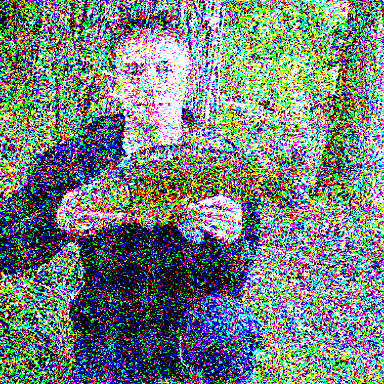

---------------
sharpen


---------------
encoding_quality


---------------
change_aspect_ratio


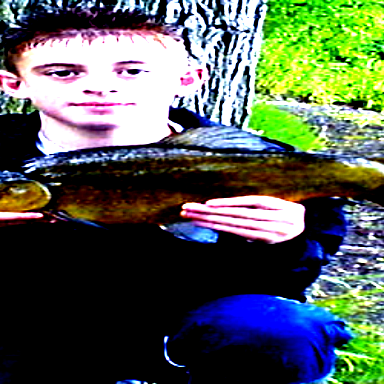

---------------
opacity


---------------
pixelization


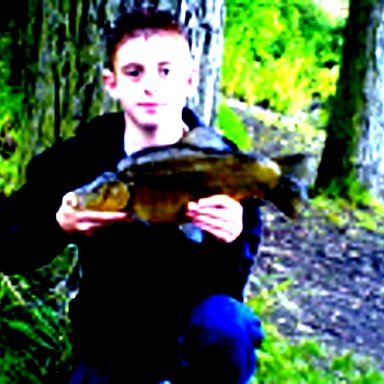

---------------
scale


---------------
color_jitter


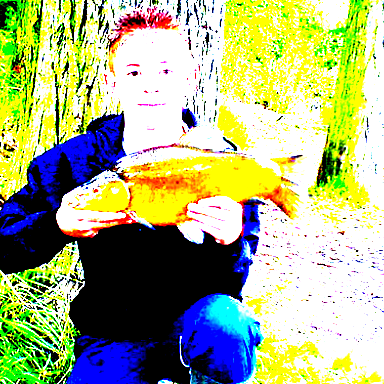

---------------
hflip


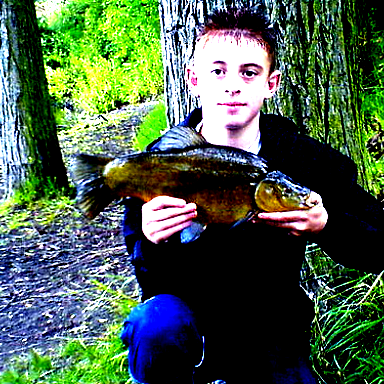

---------------
perspective_transform


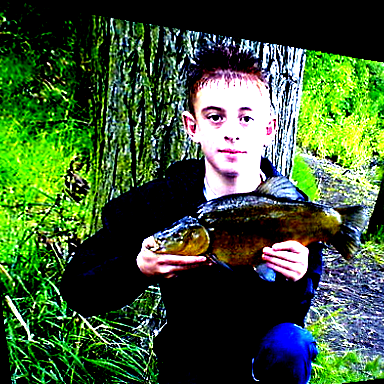

---------------
rotate


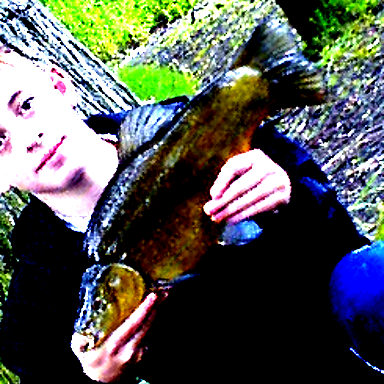

---------------
vflip


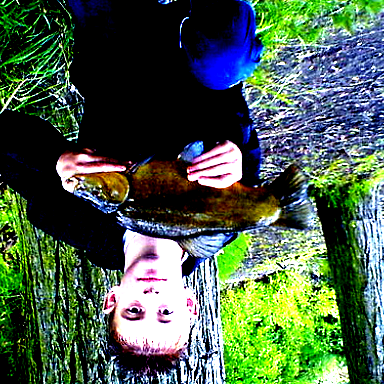

---------------
overlay_emoji


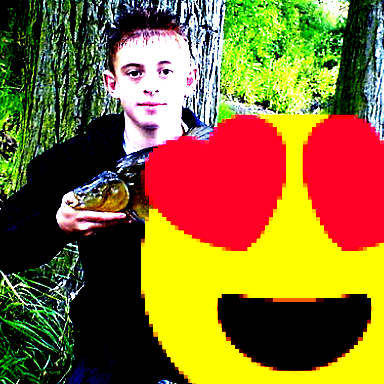

---------------
overlay_text


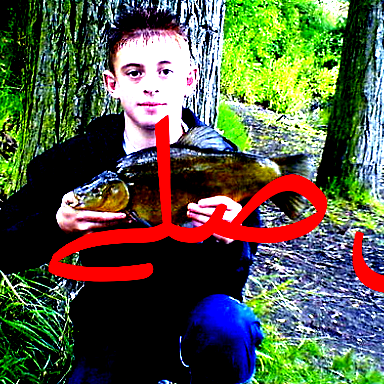

---------------
overlay_stripes


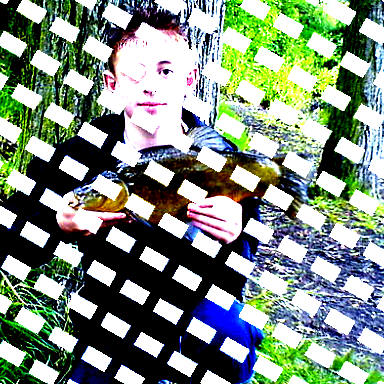

---------------
meme_format


In [8]:
# We will now run all the following augmentations on the sampled images
img = class_id_to_image_paths[0][0]
print("Original image")
display(Image.open(img))
for aug_name, aug in augmentations.items():
    print("---------------")
    print(aug_name)
    aug_tensor = transforms.Compose(
        custom_model_transforms[:1] + [aug] + custom_model_transforms[1:]
    )(img)
    with tempfile.NamedTemporaryFile(suffix=".png") as tmpfile:
        save_image(aug_tensor, tmpfile.name)
        display(Image.open(tmpfile.name))

In [9]:
# Augment all of the sampled images, write out to aug_dataset_dir
# {image_path : {aug_name: aug_image}}
aug_images = augment_images(
    sampled_test_images, aug_dataset_dir, num_images
)

Augmenting 250 images using 17 augmentations
Augmented 50/250 images
Augmented 100/250 images
Augmented 150/250 images
Augmented 200/250 images
Augmented 250/250 images


## Compute changes in top1 & top5 accuracy per augmentation
For each model in {VGG16, Efficientnet-L2, Resnet152}, we compute the difference in accuracy between the 250 unaugmented images & the 250 augmented using **each** augmentation. If this drop in accuracy is greater for augmentation A than augmentation B, then this demonstrates that the model is less robust to augmentation A than augmentation B.

### VGG

In [10]:
vgg_df = evaluate_model(models.vgg16)
vgg_df

Augmentation  Top1 acc change  Top5 acc change  Top1 acc  \
0                    NONE            0.000            0.000     0.632   
1            random_noise           -0.840           -0.632     0.000   
2         overlay_stripes           -0.808           -0.612     0.020   
3                    blur           -0.804           -0.624     0.008   
4                  rotate           -0.784           -0.620     0.012   
5            pixelization           -0.772           -0.612     0.020   
6           overlay_emoji           -0.772           -0.608     0.024   
7                 sharpen           -0.756           -0.604     0.028   
8     change_aspect_ratio           -0.756           -0.596     0.036   
9        encoding_quality           -0.740           -0.588     0.044   
10           color_jitter           -0.740           -0.592     0.040   
11                  scale           -0.684           -0.568     0.064   
12           overlay_text           -0.672           -0.568     0.064   
13                  vflip           -0.656           -0.576     0.056   
14            meme_format           -0.632           -0.532     0.100   
15  perspective_transform           -0.592           -0.552     0.080   
16                  hflip           -0.548           -0.512     0.120   
17                opacity           -0.500           -0.468     0.164   

    Top5 acc  Intensity  
0      0.840     100.00  
1      0.000       0.02  
2      0.032       7.85  
3      0.036       3.00  
4      0.056      27.78  
5      0.068      70.00  
6      0.068      64.00  
7      0.084     100.00  
8      0.084      30.00  
9      0.100      85.00  
10     0.100      16.00  
11     0.156      20.00  
12     0.168      25.00  
13     0.184     100.00  
14     0.208      40.00  
15     0.248      50.00  
16     0.292     100.00  
17     0.340      50.00

### Efficientnet

In [12]:
efficient_df = evaluate_model("efficientnet")
efficient_df

Augmentation  Top1 acc change  Top5 acc change  Top1 acc  \
0                    NONE            0.000            0.000     0.904   
1            random_noise           -0.160           -0.248     0.656   
2                    blur           -0.148           -0.220     0.684   
3           overlay_emoji           -0.088           -0.136     0.768   
4     change_aspect_ratio           -0.080           -0.148     0.756   
5                  rotate           -0.076           -0.112     0.792   
6            pixelization           -0.064           -0.120     0.784   
7                   vflip           -0.048           -0.096     0.808   
8         overlay_stripes           -0.040           -0.072     0.832   
9        encoding_quality           -0.032           -0.068     0.836   
10                  scale           -0.032           -0.060     0.844   
11                opacity           -0.024           -0.048     0.856   
12           overlay_text           -0.024           -0.012     0.892   
13            meme_format           -0.024           -0.048     0.856   
14  perspective_transform           -0.020           -0.036     0.868   
15                  hflip           -0.008           -0.020     0.884   
16                sharpen           -0.004            0.008     0.912   
17           color_jitter           -0.004           -0.032     0.872   

    Top5 acc  Intensity  
0      0.996     100.00  
1      0.836       0.02  
2      0.848       3.00  
3      0.908      64.00  
4      0.916      30.00  
5      0.920      27.78  
6      0.932      70.00  
7      0.948     100.00  
8      0.956       7.85  
9      0.964      85.00  
10     0.964      20.00  
11     0.972      50.00  
12     0.972      25.00  
13     0.972      40.00  
14     0.976      50.00  
15     0.988     100.00  
16     0.992     100.00  
17     0.992      16.00

### Resnet

In [13]:
resnet_df = evaluate_model(model_name)
resnet_df

Augmentation  Top1 acc change  Top5 acc change  Top1 acc  \
0                    NONE            0.000            0.000     0.672   
1            random_noise           -0.864           -0.672     0.000   
2                    blur           -0.848           -0.660     0.012   
3         overlay_stripes           -0.832           -0.652     0.020   
4                  rotate           -0.816           -0.656     0.016   
5            pixelization           -0.748           -0.628     0.044   
6                 sharpen           -0.744           -0.620     0.052   
7     change_aspect_ratio           -0.744           -0.636     0.036   
8        encoding_quality           -0.740           -0.620     0.052   
9            color_jitter           -0.732           -0.616     0.056   
10          overlay_emoji           -0.724           -0.584     0.088   
11                  vflip           -0.640           -0.556     0.116   
12            meme_format           -0.620           -0.572     0.100   
13           overlay_text           -0.600           -0.548     0.124   
14                  scale           -0.588           -0.540     0.132   
15  perspective_transform           -0.576           -0.516     0.156   
16                  hflip           -0.448           -0.412     0.260   
17                opacity           -0.340           -0.364     0.308   

    Top5 acc  Intensity  
0      0.876     100.00  
1      0.012       0.02  
2      0.028       3.00  
3      0.044       7.85  
4      0.060      27.78  
5      0.128      70.00  
6      0.132     100.00  
7      0.132      30.00  
8      0.136      85.00  
9      0.144      16.00  
10     0.152      64.00  
11     0.236     100.00  
12     0.256      40.00  
13     0.276      25.00  
14     0.288      20.00  
15     0.300      50.00  
16     0.428     100.00  
17     0.536      50.00

## Plot metrics
Here we plot the change in top5 accuracy for **each model** caused by **each augmentation**, computed above. You can thus see how the models "stack up" against each other: VGG & Resnet are similarly non-robust to most augmentations; Efficientnet-L2 is much more robust to all augmentations, but its biggest weakness is pixel-level augmentations like `blur` & `rotate`.

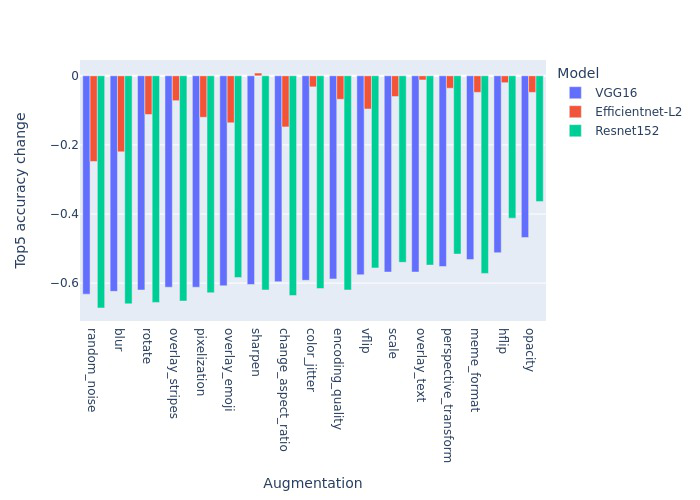

In [15]:
# top5 accuracy ∆ of the model in question caused by different
# augmentations compared to VGG & Resnet
with tempfile.TemporaryDirectory() as tempdir:
    plot = plot_metrics(
        [vgg_df, efficient_df, resnet_df],
        ["VGG16", "Efficientnet-L2", "Resnet152"],
        os.path.join(tempdir, "plot.jpg"),
    )

plot